In [1]:
import pandas as pd
import seaborn as sns
import nltk
import re, string
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import SnowballStemmer
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer

from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, f1_score, accuracy_score, confusion_matrix
from sklearn.metrics import roc_curve, auc, roc_auc_score

# bag of words
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

In [2]:
fake_df = pd.read_csv("Fake.csv")
true_df = pd.read_csv("True.csv")

In [3]:
fake_df.head()

,title,text,subject,date
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017"
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017"
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017"
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017"
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017"


### Sampling

In [4]:
fake_df['label']=0
true_df['label']=1

In [5]:
df = pd.concat([fake_df,true_df])
df.head()

,title,text,subject,date,label
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017",0
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017",0
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017",0
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017",0
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017",0


In [6]:
df=df.sample(n=10000)

c:\Users\kabuc\anaconda\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:ylabel='label'>

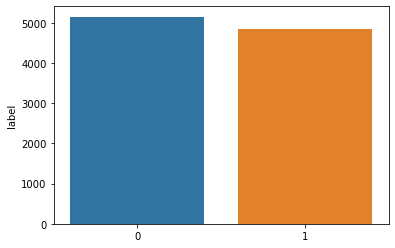

In [7]:
x= df["label"].value_counts()
sns.barplot(x.index,x)

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 2765 to 3701
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    10000 non-null  object
 1   text     10000 non-null  object
 2   subject  10000 non-null  object
 3   date     10000 non-null  object
 4   label    10000 non-null  int64 
dtypes: int64(1), object(4)
memory usage: 468.8+ KB


In [9]:
print(f"Number of duplicates:{df.duplicated().sum()}")

Number of duplicates:12


In [10]:
df = df.drop_duplicates()

In [11]:
df.reset_index(inplace=True)

In [12]:
df.subject.unique()

array(['politicsNews', 'Government News', 'left-news', 'politics',
       'worldnews', 'News', 'US_News', 'Middle-east'], dtype=object)

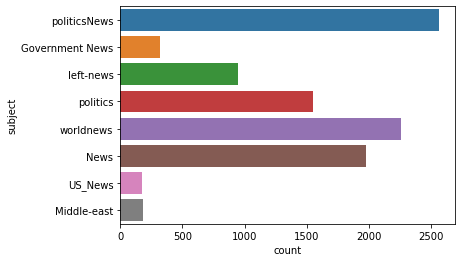

In [13]:
import matplotlib as plt
import seaborn as sns

plot=sns.countplot(y='subject',data= df,orient="h",linewidth=15)

### removing punctuation

In [14]:
import string
string.punctuation
df.head()

,index,title,text,subject,date,label
0,2765,For women at the U.S. Congress: the right to b...,WASHINGTON (Reuters) - After an internet-fuele...,politicsNews,"July 13, 2017",1
1,8736,White House candidate Trump announces Pence as...,WASHINGTON (Reuters) - Republican Donald Trump...,politicsNews,"July 15, 2016",1
2,16778,ALL HELL IS BREAKING LOOSE IN GERMANY: Citizen...,Enough is enough! German citizens are witnessi...,Government News,"Feb 7, 2016",0
3,19481,WOW! GEORGIA Refused Election Cyber-Support Fr...,This is pretty scary stuff. A federal governme...,left-news,"Dec 9, 2016",0
4,18792,GAME ON! UC Berkeley BANS Ann Coulter From Imm...,THE BIRTHPLACE OF FREE SPEECH IS NOW OFFICIALL...,left-news,"Apr 19, 2017",0


In [15]:
def pre_process(text):
    text = text.lower() 
    text=text.strip()  
    text=re.compile('<.*?>').sub('', text) 
    text = re.compile('[%s]' % re.escape(string.punctuation)).sub(' ', text)  
    text = re.sub('\s+', ' ', text)  
    text = re.sub(r'\[[0-9]*\]',' ',text) 
    text=re.sub(r'[^\w\s]', '', str(text).lower().strip())
    text = re.sub(r'\d',' ',text) 
    text = re.sub(r'\s+',' ',text) 
    return text

### removing stopwords

In [16]:
def stopword(string):
    a= [i for i in string.split() if i not in stopwords.words('english')]
    return ' '.join(a)

### lemmatization

In [17]:
#LEMMATIZATION
# Initialize the lemmatizer
wl = WordNetLemmatizer()
 
# This is a helper function to map NTLK position tags
def get_wordnet_pos(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

### tokenize

In [18]:
# Tokenize the sentence
def lemmatizer(string):
    word_pos_tags = nltk.pos_tag(word_tokenize(string)) # Get position tags
    a=[wl.lemmatize(tag[0], get_wordnet_pos(tag[1])) for idx, tag in enumerate(word_pos_tags)] # Map the position tag and lemmatize the word/token
    return " ".join(a)

In [19]:
def finalpreprocess(string):
    return lemmatizer(stopword(pre_process(string)))
df['clean_text'] = df['text'].apply(lambda x: finalpreprocess(x))
df.head()

,index,title,text,subject,date,label,clean_text
0,2765,For women at the U.S. Congress: the right to b...,WASHINGTON (Reuters) - After an internet-fuele...,politicsNews,"July 13, 2017",1,washington reuters internet fuel furor rule ba...
1,8736,White House candidate Trump announces Pence as...,WASHINGTON (Reuters) - Republican Donald Trump...,politicsNews,"July 15, 2016",1,washington reuters republican donald trump cho...
2,16778,ALL HELL IS BREAKING LOOSE IN GERMANY: Citizen...,Enough is enough! German citizens are witnessi...,Government News,"Feb 7, 2016",0,enough enough german citizen witness fast trac...
3,19481,WOW! GEORGIA Refused Election Cyber-Support Fr...,This is pretty scary stuff. A federal governme...,left-news,"Dec 9, 2016",0,pretty scary stuff federal government agency r...
4,18792,GAME ON! UC Berkeley BANS Ann Coulter From Imm...,THE BIRTHPLACE OF FREE SPEECH IS NOW OFFICIALL...,left-news,"Apr 19, 2017",0,birthplace free speech officially place oppres...


In [20]:
df.to_csv("cleaned.csv")

In [21]:
#SPLITTING THE TRAINING DATASET INTO TRAIN AND TEST

X_train, X_test, y_train, y_test = train_test_split(df["clean_text"],df["label"],test_size=0.2,shuffle=True)

In [22]:
#Tf-Idf
tfidf_vectorizer = TfidfVectorizer(use_idf=True)
X_train = tfidf_vectorizer.fit_transform(X_train) 
X_test = tfidf_vectorizer.transform(X_test)

In [23]:
#FITTING THE CLASSIFICATION MODEL using Logistic Regression(tf-idf)
model=LogisticRegression(solver = 'liblinear', C=10, penalty = 'l2')
model.fit(X_train, y_train)  
#Predict y value for test dataset
y_predict = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:,1]
print(classification_report(y_test,y_predict))
print('Confusion Matrix:',confusion_matrix(y_test, y_predict))
 
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)
print('AUC:', roc_auc)

              precision    recall  f1-score   support

           0       0.99      0.99      0.99      1024
           1       0.99      0.99      0.99       974

    accuracy                           0.99      1998
   macro avg       0.99      0.99      0.99      1998
weighted avg       0.99      0.99      0.99      1998

Confusion Matrix: [[1014   10]
 [  10  964]]
AUC: 0.9993944109342916


In [24]:
#FITTING THE CLASSIFICATION MODEL using Naive Bayes(tf-idf)
model = MultinomialNB()
model.fit(X_train, y_train)  
#Predict y value for test dataset
y_predict = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:,1]
print(classification_report(y_test,y_predict))
print('Confusion Matrix:',confusion_matrix(y_test, y_predict))
 
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)
print('AUC:', roc_auc)

              precision    recall  f1-score   support

           0       0.95      0.94      0.95      1024
           1       0.94      0.95      0.94       974

    accuracy                           0.95      1998
   macro avg       0.95      0.95      0.95      1998
weighted avg       0.95      0.95      0.95      1998

Confusion Matrix: [[967  57]
 [ 52 922]]
AUC: 0.984379010523614


In [25]:
# y_pred with DecisionTreeClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, zero_one_loss, accuracy_score

model = DecisionTreeClassifier(random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print(confusion_matrix(y_test, y_pred))
print(f'Error: {zero_one_loss(y_test, y_pred)}')
print(f'Accuracy: {accuracy_score(y_test, y_pred)}')

[[1015    9]
 [   8  966]]
Error: 0.008508508508508483
Accuracy: 0.9914914914914915
